In [4]:
# various import statements
import numpy as np
import seaborn
import tqdm
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
foo='hello'
bar='world'
import os
import sklearn
from sklearn import cluster
import pandas as pd
import re
import scanpy as sc
print(f"{foo=} {bar=}")
from torch import exp
from IPython.display import Audio, display
def allDone():
    display(Audio(url='https://notification-sounds.com/soundsfiles/Meditation-bell-sound.mp3', autoplay=True))
sc.settings.figdir=os.path.expanduser('~/WbFigures/MetaDataFigures')
import anndata

foo='hello' bar='world'


In [2]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall.h5ad'))

In [3]:
adata.obs=adata.obs.loc[:,adata.obs.isna().mean(0)!=1.]
adata.var=adata.var.loc[:,adata.var.isna().mean(0)!=1.]
adata=adata[~adata.obs['general_region'].isin(['Cultured']),:]

In [4]:
adata

View of AnnData object with n_obs × n_vars = 2290201 × 16738
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'file_name', 'demux_type', 'assignment', 'species_batch', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambiguous', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [5]:
adata=sc.AnnData(X=adata.layers['spliced'],obs=adata.obs,var=adata.var,obsm=adata.obsm,layers=adata.layers,uns=adata.uns)

In [ ]:
df=adata.obs.loc[adata.obs['species']=='mouse',:].groupby('batch_name')['region'].value_counts().unstack()
df=df.loc[df.sum(1)>1,:]
df.idxmax(1).to_dict()

In [45]:
adata.obs.loc[(adata.obs['timepoint']==110)&(adata.obs['batch_name'].str.contains('STR')),'region']='Str'
adata.obs.loc[(adata.obs['timepoint']==110)&(adata.obs['batch_name'].str.contains('HIP')),'region']='Ctx-Hip'

region_groupings={'ctx': ['Ctx-PFC','Ctx-Cing','Ctx-Clau','Ctx-Ins','Ctx-Hip','Ctx-MOp', 'Ctx-Somato','Ctx','Ctx-Temp','Ctx-Par','Ctx-Occ'],
 'bn':[ 'POA','GP','Sept','Str','Amy'],
 'ob':['OB'],
 'cp':['Choroid'],
 'mb':['MB'],
 'hb':['Pons','Cb','HB','DRG','Medulla'],
 'ge':['MGE','GE','LGE','CGE'],
 'de':['Hypo','Thal','DE'],
 'h':['Head','FB'],
 'xvctx':['ultured']}


palettes={
'ctx':seaborn.color_palette("YlOrBr",n_colors=len(region_groupings['ctx'])+2).as_hex()[:-2],
'bn':seaborn.color_palette("Blues",n_colors=len(region_groupings['bn'])+2).as_hex()[2:],
'ge':seaborn.color_palette("Reds",n_colors=len(region_groupings['ge'])+12).as_hex()[-4:],
'hb':seaborn.color_palette("Greens",n_colors=len(region_groupings['hb'])+2).as_hex()[2:],
'de':seaborn.color_palette("Purples",n_colors=len(region_groupings['de'])+2).as_hex()[2:],
'ob':['magenta'],
'mb':['cyan'],#turquoise
'cp':['yellow'],
'xvctx':['lightgray'],
'h':['tan','goldenrod']
}

adata.obs['region']=adata.obs['region'].astype('category')
regions=[]
region_colors=[]
for k in palettes.keys():
    regions+=region_groupings[k]
    region_colors+=palettes[k]

region_colors=[col for reg,col in zip(regions,region_colors) if reg in adata.obs['region'].cat.categories]
cats=[x for x in regions if x in adata.obs['region'].cat.categories]
missings=list(set(adata.obs['region'].cat.categories)-set(cats))
region_colors_dict=dict(zip(list(adata.obs['region'].cat.categories),region_colors))


paldict=dict(zip(cats+missings,region_colors+['grey' for i in range(len(missings))]))

region_colors=[paldict[x] for x in adata.obs['region'].cat.categories]
#adata.obs['region'].cat.categories=cats+missings
adata.uns['region_cats']=list(adata.obs['region'].cat.categories)
adata.uns['region_colors']=region_colors

general_region=[]
for r in adata.obs['region']:
    for k in region_groupings.keys():
        if any([r in x for x in region_groupings[k]]):
            r=k
    general_region.append(r)
adata.obs['general_region']=general_region
general_region_colors_dict={'ctx': 'orange',
 'bn':'royalblue',
 'ob':'magenta',
 'cp':'gold',
 'mb':'cyan',
 'hb':'limegreen',
 'ge':'maroon',
 'de':'mediumorchid',
 'h':'tan',
 'Cultured':'gray'}
adata.obs['general_region']=adata.obs['general_region'].astype('category')
adata.uns['general_region_colors']=[general_region_colors_dict[x] for x in adata.obs['general_region'].cat.categories]


In [7]:
file_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/originals/files.txt'

# Expand the path to an absolute path (necessary for '~')
from os.path import expanduser
file_path = expanduser(file_path)

# Read the file's content
with open(file_path, 'r') as file:
    files_content = file.read()

# The rest of the code remains the same
lines = files_content.strip().split('\n')
current_dir = ''
file_dir_dict = {}

for line in lines:
    if line.endswith(':'):
        current_dir = line[:-1]
    else:
        if line:  # This check ensures we're not adding empty lines to the dictionary
            file_dir_dict[line] = current_dir



In [8]:
adata

AnnData object with n_obs × n_vars = 2290201 × 16738
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'file_name', 'demux_type', 'assignment', 'species_batch', 'percent_ribo', 'percent_mito', 'leiden'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'region_cats', 'region_colors', 'general_region_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [9]:
adata.obs['dataset_name']=adata.obs['dataset_name'].astype(str)
adata.obs.loc[adata.obs['timepoint']==110,'dataset_name']='zhu_2018'
adata.obs.loc[(adata.obs['timepoint']!=110)&(adata.obs['species']=='macaque'),'dataset_name']='schmitz_current'

In [10]:
adata.obs.loc[adata.obs['dataset_name']=='nan','dataset_name']=adata.obs.loc[adata.obs['dataset_name']=='nan','batch_name'].replace(file_dir_dict)

/scratch/fast/15261622/ipykernel_190340/104529101.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs.loc[adata.obs['dataset_name']=='nan','dataset_name']=adata.obs.loc[adata.obs['dataset_name']=='nan','batch_name'].replace(file_dir_dict)


In [11]:
adata.obs.loc[adata.obs['dataset_name'].isin(['GW20CGE_kOut','GW20ventralthalamus_kOut']),'dataset_name']='kriegstein'
adata.obs.loc[adata.obs['dataset_name'].isin(['pollen_2022']),'dataset_name']='schmitz_current'

In [12]:
adata.obs['dataset_name']=adata.obs['dataset_name'].astype(str)

In [13]:
#hdata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/originals/KDCbVelocityPanHumanPresupervise.h5ad'),backed='r')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired v

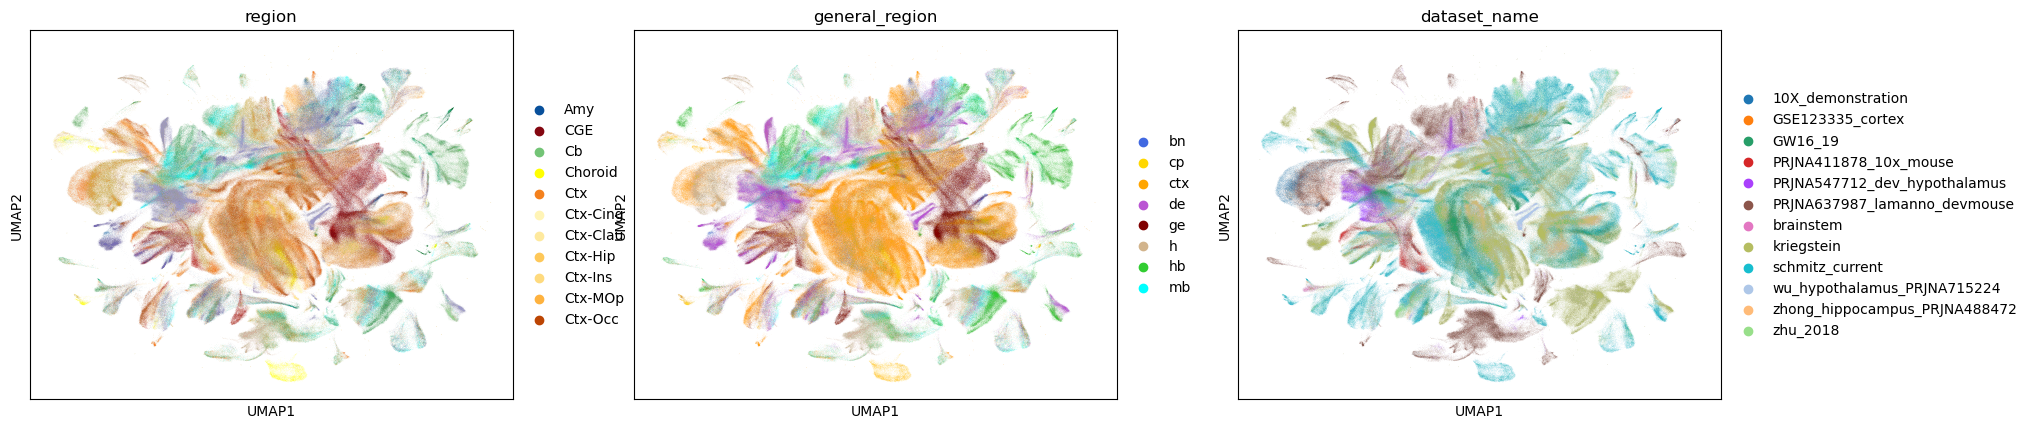

In [14]:
sc.pl.umap(adata,color=['region','general_region','dataset_name'])

In [16]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

In [122]:
sc.pp.highly_variable_genes(adata,layer='spliced',flavor='seurat_v3',n_top_genes=14000,batch_key='species')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [31]:
adata

AnnData object with n_obs × n_vars = 2290201 × 16738
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'batch', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'file_name', 'demux_type', 'assignment', 'species_batch', 'percent_ribo', 'percent_mito', 'leiden', 'n_counts'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'region_cats', 'region_colors', 'general_region_colors', 'dataset_name_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [35]:
adata.var

,n_cells,highly_variable,highly_variable_nbatches,highly_variable_intersection,mean,std,highly_variable_rank,variances,variances_norm,means
TRAPPC2,353360,False,3,False,0.091585,0.247496,13516.0,0.296496,0.754269,0.199613
C17orf49,216187,True,3,False,0.067238,0.232383,1754.0,0.697416,1.671316,0.205444
C2orf68,410871,True,3,False,0.137744,0.339803,9326.0,0.629724,0.831068,0.276583
C4orf19,22585,True,2,False,0.004606,0.055179,6818.5,0.015920,0.849211,0.011378
C4orf54,603,True,3,False,0.000146,0.010223,7826.0,0.000327,0.882454,0.000281
...,...,...,...,...,...,...,...,...,...,...
ZYG11B,254278,False,3,False,0.067634,0.219035,13153.0,0.167532,0.779451,0.130826
ZYX,229251,True,3,False,0.054287,0.189356,3612.0,0.223221,1.098889,0.129374
ZZEF1,127568,True,3,False,0.031103,0.147165,10276.0,0.075946,0.804491,0.062348
ASIP,3411,True,3,False,0.000689,0.021146,6903.0,0.002606,0.869898,0.001785


In [34]:
adata.write(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_clean.h5ad'))

In [63]:
import pandas as pd
import scipy
import os
top_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/zhong_cerebellum_PRJNA695270'
obs=pd.read_csv(os.path.join(top_path,'GSE165657_Cerebellum_aggr_barcodes.tsv.gz'),sep='\t',header=None)
var=pd.read_csv(os.path.join(top_path,'GSE165657_Cerebellum_aggr_genes.tsv.gz'),sep='\t',header=None)
mtx=scipy.io.mmread(os.path.join(top_path,'GSE165657_Cerebellum_aggr_matrix.mtx.gz'))
mtx=mtx.T.tocsr()
obs.index=list(obs[0].astype(str))
var.index=list(var[1].astype(str))
ceredata=sc.AnnData(X=mtx,obs=obs,var=var)
ceredata.obs[0]=ceredata.obs[0].astype(str)
ceredata.var[0]=ceredata.var[0].astype(str)
ceredata.var[1]=ceredata.var[1].astype(str)
ceredata.var.columns=['ensembl_id','symbol']
ceredata.obs.columns=['barcode']
ceredata.obs['dataset_name']='zhong_cerebellum_PRJNA695270'
ceredata.write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/zhong_cerebellum_PRJNA695270/human_cerebellum.h5ad')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/scanpy/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
adata=sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_clean.h5ad'))

In [103]:
df=pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/HvQvM/batch_individual.txt',header=0)
individual_dict=dict(zip(df['batch_name'],df['0']))
adata.obs['individual']=adata.obs['batch_name'].replace(individual_dict)

/scratch/fast/15309832/ipykernel_30465/2964679652.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs['individual']=adata.obs['batch_name'].replace(individual_dict)


In [3]:
cbdata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/KDCbVelocityCerebellumPresupervise.h5ad')

In [4]:
set(cbdata.obs.columns)-set(adata.obs.columns)

set()

In [5]:
set(adata.obs.columns)-set(cbdata.obs.columns)

{'assignment',
 'batch',
 'demux_type',
 'file_name',
 'latent_RT_efficiency',
 'latent_cell_probability',
 'leiden',
 'n_counts',
 'n_genes',
 'percent_mito',
 'percent_ribo',
 'species',
 'species_batch'}

In [6]:
ribo_genes=[name for name in cbdata.var_names if name.startswith('RPS') or name.startswith('RPL') ]
cbdata.obs['percent_ribo'] = np.sum(
cbdata[:, ribo_genes].X, axis=1) / np.sum(cbdata.X, axis=1)
mito_genes = [name for name in cbdata.var_names if name in ['ND1','ND2','ND4L','ND4','ND5','ND6','ATP6','ATP8','CYTB','COX1','COX2','COX3'] or name.startswith('chrM-') or name.startswith('MT-')]
cbdata.obs['percent_mito'] = np.sum(
cbdata[:, mito_genes].X, axis=1) / np.sum(cbdata.X, axis=1)
cbdata.obs['n_counts']=cbdata.raw.X.sum(1)
cbdata.obs['n_genes']=(cbdata.raw.X>0).sum(1)
cbdata.obs['species']='human'
cbdata.obs['species_batch']=cbdata.obs['species'].astype(str)+cbdata.obs['batch_name'].astype(str)
cbdata.obs['dataset_name']='zhong_cerebellum_PRJNA695270'
cbdata.obs['individual']=cbdata.obs['batch_name']

In [99]:
adata.obs

,n_genes,batch_name,dataset_name,timepoint,region,clean_cellname,full_cellname,msregion,general_region,species,percent_ribo,n_counts,log10_n_counts
TCAGACGCACTT_e14-WT8-1-0,3018,e14-WT8-1,GSE123335_cortex,14,Ctx,TCAGACGCACTT,TCAGACGCACTT_e14-WT8-1,nan,ctx,mouse,0.118148,8684.000000,3.938720
GTAGCTGGCTTT_e14-WT8-1-0,2968,e14-WT8-1,GSE123335_cortex,14,Ctx,GTAGCTGGCTTT,GTAGCTGGCTTT_e14-WT8-1,nan,ctx,mouse,0.127392,8258.000000,3.916875
TAGTATGTAATA_e14-WT8-1-0,4312,e14-WT8-1,GSE123335_cortex,14,Ctx,TAGTATGTAATA,TAGTATGTAATA_e14-WT8-1,nan,ctx,mouse,0.113218,13187.000000,4.120146
TTCGCATAGGTT_e14-WT8-1-0,2116,e14-WT8-1,GSE123335_cortex,14,Ctx,TTCGCATAGGTT,TTCGCATAGGTT_e14-WT8-1,nan,ctx,mouse,0.093285,5853.000000,3.767379
TTCATAAACCTA_e14-WT8-1-0,3927,e14-WT8-1,GSE123335_cortex,14,Ctx,TTCATAAACCTA,TTCATAAACCTA_e14-WT8-1,nan,ctx,mouse,0.063605,11084.000000,4.044696
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCCCTTGTG_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut,2133,SRR13565274_GSM5047783_GW21-04_cerebellum_Homo...,10.1038/s41467-023-43568-6,133,Cb,TTTGGTTTCCCTTGTG,TTTGGTTTCCCTTGTG_SRR13565274_GSM5047783_GW21-0...,nan,hb,human,0.093559,4809.790527,3.682126
TTTGGTTTCTGCGGCA_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut,1463,SRR13565274_GSM5047783_GW21-04_cerebellum_Homo...,10.1038/s41467-023-43568-6,133,Cb,TTTGGTTTCTGCGGCA,TTTGGTTTCTGCGGCA_SRR13565274_GSM5047783_GW21-0...,nan,hb,human,0.096942,2584.019043,3.412296
TTTGTCACAGACGCAA_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut,869,SRR13565274_GSM5047783_GW21-04_cerebellum_Homo...,10.1038/s41467-023-43568-6,133,Cb,TTTGTCACAGACGCAA,TTTGTCACAGACGCAA_SRR13565274_GSM5047783_GW21-0...,nan,hb,human,0.170210,1598.023193,3.203583
TTTGTCACATAACCTG_SRR13565274_GSM5047783_GW21-04_cerebellum_Homo_sapiens_RNA-Seq_kOut,3550,SRR13565274_GSM5047783_GW21-04_cerebellum_Homo...,10.1038/s41467-023-43568-6,133,Cb,TTTGTCACATAACCTG,TTTGTCACATAACCTG_SRR13565274_GSM5047783_GW21-0...,nan,hb,human,0.171465,9027.602539,3.955572


In [8]:
sc.pp.normalize_per_cell(cbdata)
sc.pp.log1p(cbdata)

In [9]:
adata=anndata.concat([adata,cbdata],merge='unique',uns_merge='unique')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [97]:
adata.uns['species_color_dict']=species_color_dict
adata.uns['region_colors_dict']=dict(zip(adata.obs.region.cat.categories,adata.uns['region_colors']))
general_region_palette={'ctx':palettes['ctx'][3],'de':palettes['de'][1],'h':'tan','hb':palettes['hb'][1],'ge':palettes['ge'][1],'mb':'cyan','bn':palettes['bn'][1],'cp':'yellow'}
adata.uns['general_region_color_dict']=general_region_palette

In [94]:
adata.obs.drop('percent_mito',inplace=True,axis=1)
adata.obs.drop('species_batch',inplace=True,axis=1)
adata.obs.loc[adata.obs['batch_name'].str.contains('GW0'),'timepoint']=22*7
adata.obs['species']=adata.obs['species'].astype('str').astype('category')
adata.obs['timepoint']=adata.obs['timepoint'].astype('int').astype('category')
adata.obs['dataset_name']=adata.obs['dataset_name'].astype(str)
adata.obs.loc[adata.obs['species']=='human','dataset_name']='10.1038/s41586-021-03910-8'
adata.obs.loc[adata.obs['batch_name'].str.contains('CS[0-9]+'),'dataset_name']='10.1038/s41593-020-00794-1'
adata.obs.loc[adata.obs['batch_name'].str.contains('fastqhypothalamus'),'dataset_name']='10.1016/j.stem.2021.11.009'
adata.obs.loc[adata.obs['batch_name'].str.contains('cerebellum_Homo_sapiens'),'dataset_name']='10.1038/s41467-023-43568-6'
adata.obs.loc[adata.obs['batch_name'].str.contains('fastqhippocampus'),'dataset_name']='10.1038/s41586-019-1917-5'
adata.obs.loc[adata.obs['batch_name'].str.contains('GW[0-9]+_rhombencephalon'),'dataset_name']='10.1038/s41588-019-0531-7'
adata.obs.loc[adata.obs['batch_name'].str.contains('GW23_Mesencephalon|GW23_Rhombencephalon'),'dataset_name']='Schmitz et al. (this publication)'
adata.obs.loc[(adata.obs['species']=='macaque'),'dataset_name']='Schmitz et al. (this publication)'
adata.obs.loc[(adata.obs['species']=='macaque')&(adata.obs['timepoint']==110),'dataset_name']='10.1126/science.aat80'
adata.obs['dataset_name']=adata.obs['dataset_name'].astype('category')


In [95]:
adata.uns['species_colors']=['dodgerblue','darkorange','limegreen']

In [ ]:
adata.obs['individual'].unique()

In [ ]:
#adata.write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean.h5ad')

# Remove doublets and set standard cutoff

In [2]:
adata=sc.read_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean.h5ad')

In [3]:
top_path='/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/extra/solo_outs'
l=[]
for x in os.listdir(top_path):
    if '.csv' in x:
        l.append(pd.read_csv(os.path.join(top_path,x)))

In [4]:
ddf=pd.concat(l,axis=0)
ddf.index=ddf['Unnamed: 0']
ddf.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
adata.obs['singlet']=1.
adata.obs['doublet']=0.
adata.obs.loc[:,['singlet','doublet']]=ddf

In [6]:
adata.obs.loc[:,['S_score','G2M_score','phase']]=pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/cc_scores.csv',index_col=0)

In [7]:
adata.uns['general_region_color_dict']['cp']='magenta'
adata.uns['region_colors_dict']['Choroid']='magenta'
general_region_palette=adata.uns['general_region_color_dict']

In [8]:
adata[(adata.obs['n_genes']>800)&(adata.obs['singlet']>0.6),:]

View of AnnData object with n_obs × n_vars = 1913938 × 16738
    obs: 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'percent_ribo', 'n_counts', 'log10_n_counts', 'individual', 'singlet', 'doublet', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means'
    uns: 'general_region_color_dict', 'general_region_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'region_cats', 'region_colors', 'region_colors_dict', 'species_color_dict', 'species_colors', 'umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [9]:
adata=adata[(adata.obs['n_genes']>800)&(adata.obs['singlet']>0.6),:]

In [10]:
adata

View of AnnData object with n_obs × n_vars = 1913938 × 16738
    obs: 'n_genes', 'batch_name', 'dataset_name', 'timepoint', 'region', 'clean_cellname', 'full_cellname', 'msregion', 'general_region', 'species', 'percent_ribo', 'n_counts', 'log10_n_counts', 'individual', 'singlet', 'doublet', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std', 'highly_variable_rank', 'variances', 'variances_norm', 'means'
    uns: 'general_region_color_dict', 'general_region_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'region_cats', 'region_colors', 'region_colors_dict', 'species_color_dict', 'species_colors', 'umap'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [ ]:
adata.write_h5ad('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad')

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/pyro/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value t

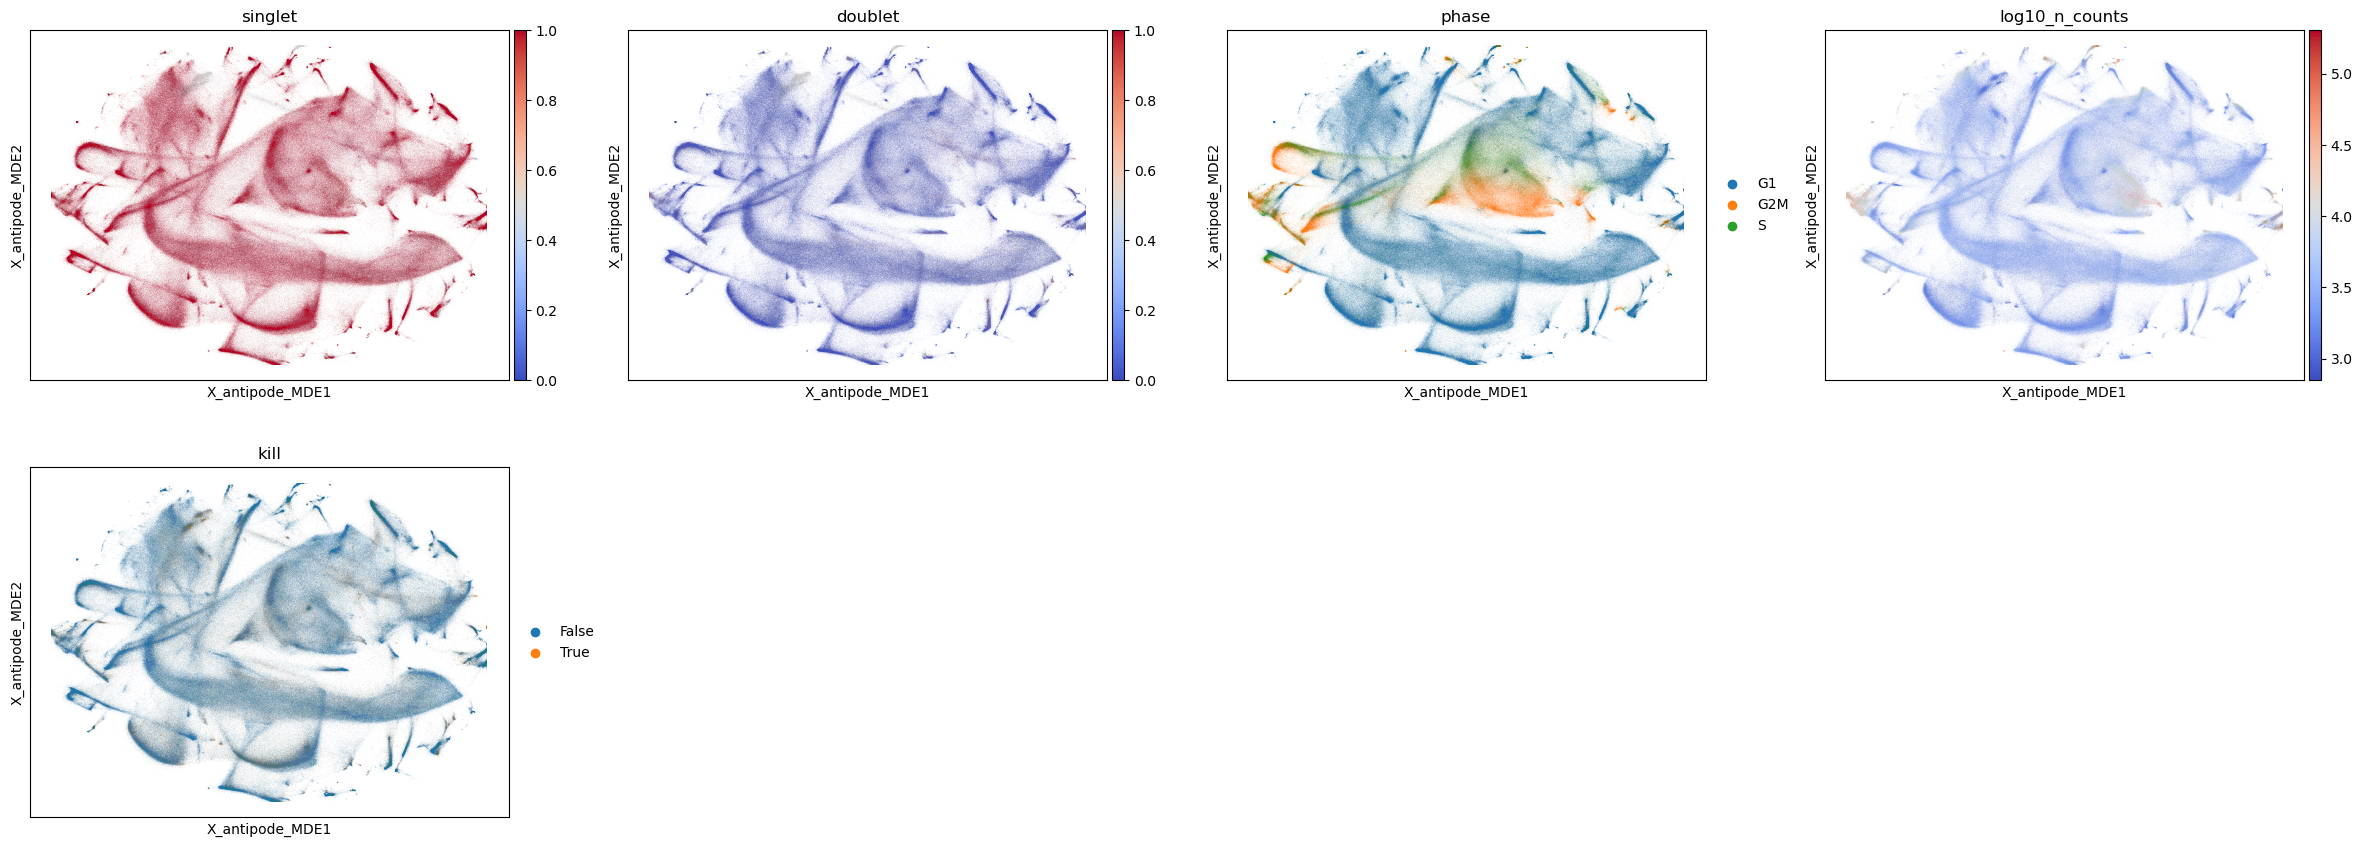

In [26]:
sc.pl.embedding(
    adata,
    basis='X_antipode_MDE',
    color=['singlet','doublet','phase','log10_n_counts','kill'],
    cmap='coolwarm'
)


In [ ]:
names = sorted(adata.uns['region_colors_dict'].values(), key=lambda c: tuple(matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(c))))
names
inv_map = {v: k for k, v in adata.uns['region_colors_dict'].items()}
sorted_color_dict=dict(zip([inv_map[x] for x in names],names))
df=(adata.obs.groupby(['species','timepoint','batch_name'])['region'].value_counts()>1).astype(int).unstack().reset_index().drop('batch_name',axis=1).groupby(['species','timepoint']).sum()
df=df.loc[df.sum(1)>0,:]
df.index=df.index.droplevel(0)#Remove species name from labels for prettiness
axes = df.loc[:,sorted_color_dict.keys()].plot.bar(stacked=True,legend=False,color=adata.uns['region_colors_dict'],xlabel='PCD',width=0.8,figsize=(16,8),edgecolor='darkgrey',ylabel='# Samples')
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(os.path.join(sc.settings.figdir,'master_sample_counts.svg'),format = "svg")

In [ ]:
names = sorted(adata.uns['region_colors_dict'].values(), key=lambda c: tuple(matplotlib.colors.rgb_to_hsv(matplotlib.colors.to_rgb(c))))
names
inv_map = {v: k for k, v in adata.uns['region_color_dict'].items()}
sorted_color_dict=dict(zip([inv_map.get(x,'grey') for x in names],names))
df=adata.obs.groupby(['species','timepoint'])['region'].value_counts().unstack()
df=df.loc[df.sum(1)>0,:]
df.index=df.index.droplevel(0)#Remove species name from labels for prettiness
axes = df.loc[:,[x for x in sorted_color_dict.keys() if x in df.columns]].plot.bar(stacked=True,legend=False,color=adata.uns['region_colors_dict'],width=0.8,figsize=(16,8),edgecolor='darkgrey',xlabel='PCD',ylabel='# Cells')
axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(os.path.join(sc.settings.figdir,'master_cell_counts.svg'),format = "svg")

In [ ]:
samplegroups={'FB':'vt',
'bn':'vt',
'ctx':'ctx',
'cp':'vt',
'de':'de',
'ge':'vt',
'h':'vt',
'hb':'hb',
'mb':'mb'}
adata.obs['sample_region']=adata.obs['general_region'].replace(samplegroups)
adata.obs['region_species']=adata.obs['sample_region'].astype(str)+'_'+adata.obs['species'].astype(str)

In [ ]:
general_region_palette={'ctx':palettes['ctx'][3],'de':palettes['de'][1],'hb':palettes['hb'][1],'h':'tan','ge':palettes['ge'][1],'mb':'cyan','bn':palettes['bn'][1],'cp':'magenta'}

In [ ]:
axes = adata.obs['general_region'].value_counts().plot.bar(stacked=False,legend=False,color=general_region_palette.values(),width=0.8,figsize=(4,4),edgecolor='darkgrey',ylabel='Cells')
#axes.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.savefig(os.path.join(sc.settings.figdir,'general_region_counts.svg'),format = "svg")

In [ ]:
"""
adata.obs.groupby('species')['sample_region'].value_counts(normalize=False).unstack().T.plot.bar()
plt.ylabel('cells')
plt.savefig(os.path.join(sc.settings.figdir,'training_group_counts.pdf'),format = "pdf")

#Normalized by species (Percent of species cells)
adata.obs.groupby('species')['sample_region'].value_counts(normalize=True).unstack().T.plot.bar()
plt.ylabel('% of species\' cells')
plt.savefig(os.path.join(sc.settings.figdir,'training_group_proportions.pdf'),format = "pdf")
"""

In [ ]:
species_color_dict=dict(zip(adata.obs['species'].cat.categories,adata.uns['species_colors']))
adata.obs['timepoint']=adata.obs['timepoint'].astype(int)
for s in adata.obs.species.unique():
    adata.obs.loc[adata.obs.species==s,'timepoint'].value_counts().sort_index().plot.bar(color=species_color_dict[s])
    plt.title(s)
    plt.xlabel('PCD')
    plt.ylabel('cells')
    plt.savefig(os.path.join(sc.settings.figdir,s+'_timepoint_counts.pdf'),format = "pdf")
    plt.show()


In [ ]:
species_color_dict=dict(zip(adata.obs['species'].cat.categories,adata.uns['species_colors']))

In [ ]:
for s in adata.obs.species.unique():
    adata.obs.loc[adata.obs.species==s,'dataset_name'].astype(str).value_counts().sort_index().plot.bar(color=adata.uns['species_color_dict'][s])
    plt.title(s)
    plt.savefig(os.path.join(sc.settings.figdir,s+'_dataset_counts.svg'),format = "svg")
    plt.show()

In [ ]:
#adata.write(os.path.expanduser('~/HvQvMall_ready.h5ad'))
"""
random_indices=np.random.choice(adata.obs.index, size=len(adata.obs.index), replace=False)
import gc
def chunks(xs, n):
    n = max(1, n)
    return (xs[i:i+n] for i in range(0, len(xs), n))

samplegroups={'FB':'vt',
'bn':'vt',
'ctx':'ctx',
'cp':'vt',
'de':'de',
'ge':'vt',
'h':'vt',
'hb':'hb',
'mb':'mb'}
adata.obs['sample_region']=adata.obs['general_region'].replace(samplegroups)
adata.obs['region_species']=adata.obs['sample_region'].astype(str)+'_'+adata.obs['species'].astype(str)
adata.uns['batch_cats']=dict(zip([str(x) for x in adata.obs['batch_name'].cat.categories],[str(x) for x in sorted(set(adata.obs['batch_name'].cat.codes))]))
K=10
adata_paths=[]
for i,c in enumerate(chunks(random_indices,len(random_indices)//10)):
    print(i)
    adata1=adata[c,:]
    adata_path=os.path.expanduser('~/HvQvM/HvQvMall_part'+str(i)+'.h5ad')
    adata1.write(adata_path)
    adata_paths.append(adata_path)
    del adata1
    gc.collect()
"""

In [ ]:
adata.obs['log10_n_counts']=np.log10(adata.obs['n_counts'])
adata.obs['batch_name']=adata.obs['batch_name'].astype('category')
for s in adata.obs.species.unique():
    with plt.rc_context({"figure.figsize": (20, 6), "figure.dpi": (300)}):
        sc.pl.violin(adata[adata.obs.species==s,:].to_memory(),groupby='batch_name',keys='log10_n_counts',stripplot=False,rotation=90,save=s+'_count_violins.svg',palette=sc.pl.palettes.godsnot_102)


In [ ]:
adata.obs['log10_n_genes']=np.log10(adata.obs['n_genes'])
adata.obs['batch_name']=adata.obs['batch_name'].astype('category')
for s in adata.obs.species.unique():
    with plt.rc_context({"figure.figsize": (20, 6), "figure.dpi": (300)}):
        sc.pl.violin(adata[adata.obs.species==s,:].to_memory(),groupby='batch_name',keys='log10_n_genes',stripplot=False,rotation=90,save=s+'_genes_violins.svg',palette=sc.pl.palettes.godsnot_102)


In [6]:
import sys
import antipode
from antipode.antipode_model import *
import antipode.model_functions
from antipode.model_functions import *
import antipode.model_distributions
from antipode.model_distributions import *
import antipode.model_modules
from antipode.model_modules import *
import antipode.train_utils
from antipode.train_utils import *
import antipode.plotting
from antipode.plotting import *
from antipode.antipode_mixins import AntipodeTrainingMixin, AntipodeSaveLoadMixin

/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/code/scANTIPODE/antipode/antipode_mixins.py:43: SyntaxWarning: invalid escape sequence '\$'
  pstore={n:pstore[n] for n in pstore.keys() if not re.search('encoder|classifier|be_nn|\$\$\$',n)}


In [3]:
adata = sc.read_h5ad('/home/matthew.schmitz/Matthew/models/1.9.1.8.5_Dev_NBSoftmaxShift_noQ_IP/p3_adata.h5ad',backed='r')

In [28]:
adata = sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets.h5ad'),backed='r')

In [29]:
adata.obs.index = adata.obs.index.str.replace('-[0-9]+-[0-9]+$','',regex=True)
adata.write_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_2.h5ad'))

In [35]:
adata = antipode.anndata_utils.read_h5ad_backed_selective(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_2.h5ad'),
    mode='r', selected_keys=['S_score','G2M_score','phase','log10_n_counts','region', 'batch_name','species','spliced', 'var', 'uns'])

adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict()['female'])
adata.obsm['phase_sex']=np.concatenate([adata.obs['S_score'].to_numpy().reshape(-1,1),adata.obs['G2M_score'].to_numpy().reshape(-1,1),adata.obs['log10_n_counts'].to_numpy().reshape(-1,1),antipode.model_functions.numpy_onehot(adata.obs['female'].cat.codes)],axis=1)
adata.obsm['phase_sex']=adata.obsm['phase_sex']/np.abs(adata.obsm['phase_sex']).max(0)#Scale so max value is magnitude 1


/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/matthew.schmitz/Matthew/utils/miniforge3/envs/rapids-24.12/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/scratch/fast/22590941/ipykernel_15328/1083173985.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs['female']=adata.obs['batch_name'].replace(pd.read_csv('/home/matthew.schmitz/Matthew/data/taxtest/extra/inferred_sex.csv',index_col=0).to_dict

In [36]:
# adata = sc.read_h5ad(os.path.expanduser('/allen/programs/celltypes/workgroups/rnaseqanalysis/EvoGen/Team/Matthew/data/taxtest/HvQvM/HvQvMall_cere_clean_nodoublets_2.h5ad'),backed='r')

In [53]:
seaborn.histplot(np.log10(adata.layers['spliced'][0:100].todense()+1).flatten(),bins=100)
plt.xlabel('gene count')


KeyboardInterrupt



In [65]:
percentages = np.cumsum(np.sort(adata.layers['spliced'].sum(0)))/adata.layers['spliced'].sum()

In [73]:
1-percentages.A1[-2500]

np.float32(0.7580456)

<Axes: >

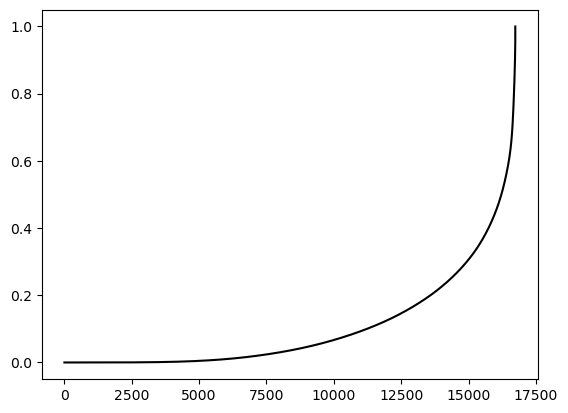

In [69]:
seaborn.lineplot(x=list(range(len(percentages.A1))),y=percentages.A1,c='black')

In [54]:
(adata.layers['spliced'][0:100].todense()>0).mean()

np.float64(0.1680152945393715)

Text(50.722222222222214, 0.5, 'cells')

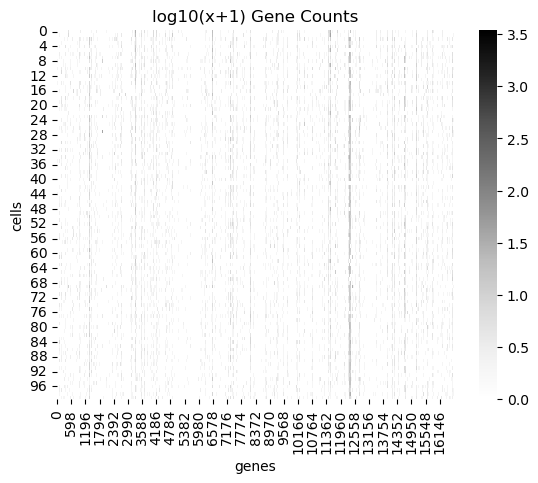

In [55]:
seaborn.heatmap(np.log10(adata.layers['spliced'][0:100].todense()+1),cmap='Greys')
plt.title('log10(x+1) Gene Counts')
plt.xlabel('genes')
plt.ylabel('cells')

In [34]:
import h5py
import anndata
from anndata import AnnData
from pathlib import Path
from typing import Union, Literal, List, Dict
from ete3 import Tree
from scipy.sparse import csr_matrix
import pandas as pd

def h5_tree(val):
    tree = {}
    for key, item in val.items():
        if isinstance(item, h5py._hl.group.Group):
            tree[key] = h5_tree(item)
        else:
            try:
                tree[key] = len(item)
            except TypeError:
                tree[key] = "scalar"
    return tree


def dict_to_ete3_tree(d, parent=None):
    if parent is None:
        parent = Tree(name="root")
    for k, v in d.items():
        child = parent.add_child(name=k)
        if isinstance(v, dict):
            dict_to_ete3_tree(v, child)
    return parent


def ete3_tree_to_dict(tree):
    def helper(node):
        if node.is_leaf():
            return node.name
        d = {}
        for child in node.get_children():
            d[child.name] = helper(child)
        return d

    root_dict = {}
    for child in tree.get_children():
        root_dict[child.name] = helper(child)
    return root_dict


def prune_tree(tree, keys):
    t = dict_to_ete3_tree(tree)

    nodes_to_keep = set()

    # Find all nodes matching the keys and collect their ancestors and descendants
    for key in keys:
        for node in t.search_nodes(name=key):
            nodes_to_keep.update(node.iter_ancestors())
            nodes_to_keep.update(node.iter_descendants())
            nodes_to_keep.add(node)

    # Prune the original tree by removing nodes that are not in nodes_to_keep
    for node in t.traverse("postorder"):
        if node not in nodes_to_keep and node.up:
            node.detach()

    pruned_dict = ete3_tree_to_dict(t)
    return pruned_dict


def read_h5_to_dict(h5_group, pruned_tree):
    def helper(group, subtree):
        result = {}
        for key, value in subtree.items():
            if isinstance(value, dict):
                # Ensure key exists in the group before trying to access it
                if key in group:
                    result[key] = helper(group[key], value)
                else:
                    result[key] = None  # Handle missing keys gracefully
            else:
                # Ensure key exists in the group before trying to access it
                if key in group:
                    if isinstance(group[key], h5py.Dataset):
                        if group[key].shape == ():
                            result[key] = group[key][()]  # Read scalar dataset
                        else:
                            data = group[key][:]
                            # Decode binary strings to regular strings if necessary
                            if data.dtype.kind == "S":
                                data = data.astype(str)
                            result[key] = data  # Read non-scalar dataset
                    else:
                        result[key] = None  # Handle non-dataset values gracefully
                else:
                    result[key] = None  # Handle missing keys gracefully
        return result

    return helper(h5_group, pruned_tree)


def convert_to_dataframe(data):
    df_dict = {}
    for key, value in data.items():
        if isinstance(value, dict) and "categories" in value and "codes" in value:
            categories = [
                cat.decode("utf-8") if isinstance(cat, bytes) else cat
                for cat in value["categories"]
            ]
            codes = value["codes"]
            df_dict[key] = pd.Categorical.from_codes(codes, categories)
        elif (
            isinstance(value, dict)
            and "data" in value
            and "indices" in value
            and "indptr" in value
        ):
            df_dict[key] = csr_matrix(
                (value["data"], value["indices"], value["indptr"])
            )
        else:
            if value.dtype.kind == "S":
                value = [
                    v.decode("utf-8") if isinstance(v, bytes) else v for v in value
                ]
            df_dict[key] = value
    df = pd.DataFrame(df_dict)
    return df


def handle_special_keys(data):
    if "obs" in data:
        data["obs"] = convert_to_dataframe(data["obs"])
    if "var" in data:
        data["var"] = convert_to_dataframe(data["var"])
    if ("layers" in data) or (data == "X"):
        try:
            for layer in data["layers"]:
                data["layers"][layer] = csr_matrix(
                    (
                        data["layers"][layer]["data"],
                        data["layers"][layer]["indices"],
                        data["layers"][layer]["indptr"],
                    )
                )
        except:
            pass
    return data


def read_h5ad_backed_selective(
    filename: Union[str, Path],
    mode: Literal["r", "r+"],
    selected_keys: List[str] = [],
    return_dict: bool = False,
) -> AnnData:
    f = h5py.File(filename, mode)

    selected_keys += ["_index"]

    tree = h5_tree(f)
    selected_tree = prune_tree(tree, selected_keys)
    with f:
        d = read_h5_to_dict(f, selected_tree)
        d = handle_special_keys(d)
    d["filename"] = filename
    d["filemode"] = mode
    if return_dict:
        return d
    else:
        adata = AnnData(**d)
        if "_index" in adata.obs.columns:
            index_series = adata.obs["_index"].astype('string')
            adata.obs.index = list(index_series)
            adata.obs.drop("_index",axis=1, inplace=True)
        if "_index" in adata.var.columns:
            index_series = adata.var["_index"].astype('string')
            adata.var.index = list(index_series)
            adata.var.drop("_index",axis=1, inplace=True)
        return adata

